In [1]:
%matplotlib inline


# A 250-hPa Hemispheric Map using Python


This example plots a hemispheric plot of GFS 250-hPa Geopotential Heights and
wind speed in knots.


In [2]:
# =======
# modules

# time
from datetime import datetime, timedelta
# plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# metpy
import metpy.calc as mpcalc
from metpy.units import units
# netcdf4
from netCDF4 import num2date
# useful 
import numpy as np
import scipy.ndimage as ndimage 
# weather data
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

In [106]:
# =======
# define Dataset and Time

# Set the time range
now = datetime.utcnow() #current
end = now + timedelta(days=7) # end of forecast
dt = 8 # take only every nth time
print(end)

# set geography
north = 90; south = 0; east = 360; west = 0

# define dataset from THREDDS catalog 
latest_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/latest.xml')
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
print(best_gfs.datasets)

# available THREDDS catalog 
#cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
#print('available THREDDS catalog: ', list(cat.catalog_refs))

2019-12-28 01:39:08.283890
['Best GFS Half Degree Forecast Time Series']


In [107]:
# =======
# Latest GFS Dataset

# pull out this dataset and get the NCSS access point
latest_ds = list(best_gfs.datasets.values())[0]
# Create NCSS object to access the NetcdfSubset
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])

# Query for Latest GFS Run
# NOTE: different number of vertical levels for geopot and wind

# geopotential height
query_geopot = ncss.query().time_range(now, end).strides(time=dt).lonlat_box(north = north, south = south, east = east, west = west).vertical_level(25000).accept('netcdf4')    # use time(now) to get only current timestep
query_geopot.variables('Geopotential_height_isobaric').add_lonlat()

# wind
query_wind = ncss.query().time_range(now, end).strides(time=dt).lonlat_box(north = north, south = south, east = east, west = west).vertical_level(25000).accept('netcdf4')    # use time(now) to get only current timestep
query_wind.variables('u-component_of_wind_isobaric',
                    'v-component_of_wind_isobaric').add_lonlat()

# variables needed for potential vorticity
query = ncss.query().time(now).lonlat_box(north = north, south = south, east = east, west = west).accept('netcdf4')    # use time(now) to get only current timestep
query.variables('Temperature_isobaric','u-component_of_wind_isobaric', 'v-component_of_wind_isobaric').add_lonlat()

# Actually getting (request) the data
#data_geopot = ncss.get_data(query_geopot)
#data_wind = ncss.get_data(query_wind)
data = ncss.get_data(query)

In [109]:

print(list(data.variables))

press = data.variables['isobaric6'][:] * units.Pa
press = press[:, None, None]
print(np.shape(press))
print(data.variables['isobaric6'][:].astype(int))
print(len(data.variables['isobaric6'][:]))
print(data.variables['isobaric'][:])
print(len(data.variables['isobaric'][:]))


temperature = data.variables['Temperature_isobaric'][0] * units.kelvin

print('temp: ',np.shape(temperature))

theta = mpcalc.potential_temperature(pres[:, None, None], temperature)

print(np.shape(theta))

uwnd = data.variables['u-component_of_wind_isobaric'][0] * units.meter / units.second

vwnd = data.variables['v-component_of_wind_isobaric'][0] * units.meter / units.second
print('wind: ',np.shape(vwnd))    

# Compute dx and dy spacing for use in vorticity calculation
lats = data.variables['lat'][:]
lons = data.variables['lon'][:]
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)  
print(np.shape(dx))   
print(np.shape(dy))   
print(np.shape(lats))   
print(np.shape(dx[None, :, :]))  


# Comput the PV on all isobaric surfaces
#pv = mpcalc.potential_vorticity_baroclinic(thta, pres[:, None, None], uwnd, vwnd,
#                                           dx[None, :, :], dy[None, :, :],
#                                           lats[None, :, None] * units('degrees'))


#ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/'
                     #'casestudies/python-gallery/GFS_20101026_1200.nc').metpy.parse_cf()
print(ds['Temperature_isobaric'].shape)
print(ds['isobaric3'].shape)
print(ds['u-component_of_wind_isobaric'].shape)
lats = ds.lat
lons = ds.lon
print(np.shape(lats))  
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
print(np.shape(dx)) 
print(np.shape(dy)) 

['Temperature_isobaric', 'reftime1', 'time1', 'isobaric6', 'lat', 'lon', 'LatLon_Projection', 'u-component_of_wind_isobaric', 'isobaric', 'v-component_of_wind_isobaric']
(34, 1, 1)
[    40    100    200    300    500    700   1000   1500   2000   3000
   4000   5000   7000  10000  15000  20000  25000  30000  35000  40000
  45000  50000  55000  60000  65000  70000  75000  80000  85000  90000
  92500  95000  97500 100000]
34
[   100.    200.    300.    500.    700.   1000.   2000.   3000.   5000.
   7000.  10000.  15000.  20000.  25000.  30000.  35000.  40000.  45000.
  50000.  55000.  60000.  65000.  70000.  75000.  80000.  85000.  90000.
  92500.  95000.  97500. 100000.]
31
temp:  (34, 181, 720)
(34, 181, 720)
wind:  (31, 181, 720)
(181, 719)
(180, 720)
(181,)
(1, 181, 719)
(1, 26, 361, 720)
(26,)
(1, 26, 361, 720)
(361,)
(361, 719)
(360, 720)


The next cell will take the downloaded data and parse it to different variables
for use later on. Add a cyclic point using the cartopy utility add_cyclic_point
to the longitudes (the cyclic dimension) as well as any data that is being
contoured or filled.



In [16]:
print(list(data_geopot.variables))

lat = data_geopot.variables['lat'][:]
lon = data_geopot.variables['lon'][:]

# Converting times using the num2date function available through netCDF4
times = data_geopot.variables['time2']
vtimes = num2date(times[:], times.units)
print(len(times))

# Smooth the 250-hPa heights using a gaussian filter from scipy.ndimage
hgt_250, lon = cutil.add_cyclic_point(data_geopot.variables['Geopotential_height_isobaric'][:],
                                      coord=lon)
print(np.shape(hgt_250))
Z_250 = ndimage.gaussian_filter(hgt_250[:, 0, :, :], sigma=3, order=0)
print(np.shape(Z_250))

u250 = (units(data_wind.variables['u-component_of_wind_isobaric'].units) *
        data_wind.variables['u-component_of_wind_isobaric'][:, 0, :, :])
v250 = (units(data_wind.variables['v-component_of_wind_isobaric'].units) *
        data_wind.variables['v-component_of_wind_isobaric'][:, 0, :, :])
u250 = u250.units * cutil.add_cyclic_point(u250)
v250 = v250.units * cutil.add_cyclic_point(v250)
wspd250 = mpcalc.wind_speed(u250, v250)

['Geopotential_height_isobaric', 'time2', 'isobaric6', 'lat', 'lon', 'LatLon_Projection']
7
(7, 1, 181, 721)
(7, 181, 721)


The next cell sets up the geographic details for the plot that we are going to do later.
This is done using the Cartopy package. We will also bring in some geographic data to
geo-reference the image for us.



0


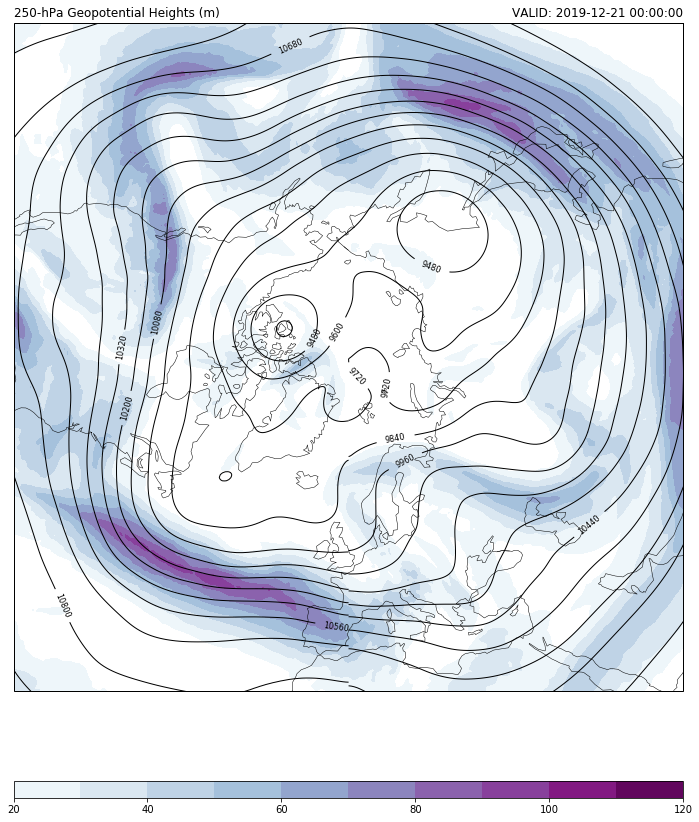

In [26]:
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.NorthPolarStereo(central_longitude=0.0)

# Make a grid of lat/lon values to use for plotting with Basemap.
lons, lats = np.meshgrid(lon, lat)

for iii in range(0,len(times),7):
    print(iii)
    fig = plt.figure(1, figsize=(12., 13.))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02],
                           bottom=.07, top=.99, hspace=0.01, wspace=0.01)

    ax = plt.subplot(gs[0], projection=plotcrs)
    ax.set_title('250-hPa Geopotential Heights (m)', loc='left')
    ax.set_title('VALID: {}'.format(vtimes[iii]), loc='right')

    #   ax.set_extent([west long, east long, south lat, north lat])
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
    ax.coastlines(edgecolor='black', linewidth=0.5)

    clev250 = np.arange(9000, 12000, 120)
    cs = ax.contour(lons, lats, Z_250[iii,:,:], clev250, colors='k',
                    linewidths=1.0, linestyles='solid', transform=datacrs)
    plt.clabel(cs, fontsize=8, inline=1, inline_spacing=10, fmt='%i',
               rightside_up=True, use_clabeltext=True)

    clevsped250 = np.arange(20, 130, 10)
    cmap = plt.cm.get_cmap('BuPu')
    cf = ax.contourf(lons, lats, wspd250[iii,:,:], clevsped250, cmap=cmap, transform=datacrs)
    cax = plt.subplot(gs[1])
    cbar = plt.colorbar(cf, cax=cax, orientation='horizontal', extend='max', extendrect=True)

    plt.savefig('../figures/test' + str(iii) + '.png')



In [ ]:
from datetime import datetime
import metpy.calc as mpcalc
from siphon.catalog import TDSCatalog
import xarray as xr

cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
best = cat.datasets['Best GFS Half Degree Forecast Time Series']
subset_access = best.subset()
query = subset_access.query()
query.time(datetime.utcnow())
query.variables('Temperature_isobaric', 'Geopotential_height_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric',
                'Relative_humidity_isobaric')
query.lonlat_box(west=-130, east=-50, south=10, north=60)
query.accept('netcdf4')
nc = subset_access.get_data(query)
from xarray.backends import NetCDF4DataStore
ds = xr.open_dataset(NetCDF4DataStore(nc))
ds = ds.metpy.parse_cf()
temperature = ds['Temperature_isobaric'][0]

lon = temperature.metpy.x

u = ds['u-component_of_wind_isobaric'][0]
temperature.metpy.vertical
u.metpy.vertical